In [ ]:
img_paths = "/content/drive/MyDrive/DL2023p-licd/S06/Actividad 6/data/images"
annotations_path = "/content/drive/MyDrive/DL2023p-licd/S06/Actividad 6/data/airplanes.csv"

import os
import random
import cv2 as cv

import tensorflow as tf
from tensorflow import keras
from tensorflow.data import AUTOTUNE

from tensorflow.keras.layers import Conv2D, Flatten, Dense, Input
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

In [ ]:
def preprocess_bbox(img_src, annotation):
  filename, x_min, y_min, x_max, y_max = annotation.split(",")
  img_path = img_src + "/" + filename
  img = cv.imread(img_path)
  h, w, _ = img.shape
  annotation="".join([img_path, ",", str(float(x_min)/w), ",",
                   str(float(y_min)/h), ",",
                   str(float(x_max)/w), ",",
                   str(float(y_max)/h)])
  return annotation

In [ ]:
txt=preprocess_bbox("/content/drive/MyDrive/DL2023p-licd/S06/Actividad 6/data/images", "image_0720.jpg,50,31,352,118")
print(txt)



/content/drive/MyDrive/DL2023p-licd/S06/Actividad 6/data/images/image_0720.jpg,0.12376237623762376,0.2152777777777778,0.8712871287128713,0.8194444444444444


In [ ]:
def build_datasets(images_path, annotations_path, train_split=0.9, val_split=0.1):
  
  examples = []
  
  annotations = open(annotations_path).read().splitlines()
  
  examples = [preprocess_bbox(images_path, item) for item in annotations]

  # Generar un indice aleatorio
  random.shuffle(examples)

  # Splits sobre el indice de los dataset: training y test
  s = int(len(examples)*train_split)
  train_examples = examples[:s]
  test_examples = examples[s:]

  # Splits sobre train_index para obtener los indieces de: train y test
  s = int(len(train_examples)*val_split)
  val_examples = train_examples[:s]
  train_examples = train_examples[s:]

  return train_examples, val_examples, test_examples

In [ ]:
train_data, val_data, test_data = build_datasets(img_paths, annotations_path, 0.95, 0.1)

In [ ]:
print(train_data[0])

/content/drive/MyDrive/DL2023p-licd/S06/Actividad 6/data/images/image_0696.jpg,0.14646464646464646,0.18620689655172415,0.8762626262626263,0.8137931034482758


In [ ]:
import sys

def loadExample(example):

  #Extrar información de la cadena de texto
  # image_path y bbox
  str_tensors = tf.strings.split(example, sep=",")

  #Cargar imagen
  img = tf.io.read_file(str_tensors[0])
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.convert_image_dtype(img, dtype=tf.float16)
  img = tf.image.resize(img, (128, 128))

  x_min=tf.strings.to_number(str_tensors[1])
  y_min=tf.strings.to_number(str_tensors[2])
  x_max=tf.strings.to_number(str_tensors[3])
  y_max=tf.strings.to_number(str_tensors[4])

  #Salida esperada
  label = [x_min, y_min, x_max, y_max]

  return (img, label)

In [ ]:
img, label = loadExample(train_data[0])

In [ ]:
print(type(train_data))

<class 'list'>


In [ ]:
# Datasets

bath_size=32
train_dataset = tf.data.Dataset.from_tensor_slices(train_data)
train_dataset = (train_dataset
                 .shuffle(len(train_data))
                 .map(loadExample, num_parallel_calls=AUTOTUNE)
                 .cache()
                 .batch(bath_size)
                 .prefetch(AUTOTUNE)
                 )

val_dataset = tf.data.Dataset.from_tensor_slices(val_data)
val_dataset = (val_dataset
                 .shuffle(len(val_data))
                 .map(loadExample, num_parallel_calls = AUTOTUNE)
                 .cache()
                 .batch(bath_size)
                 .prefetch(AUTOTUNE)
                 )

In [ ]:
vgg = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(128,128, 3)))
vgg.trainable=True
output_vgg = vgg.output
x = Flatten()(output_vgg)
x = Dense(128, activation="relu")(x)
x = Dense(64, activation="relu")(x)
x = Dense(32, activation="relu")(x)
output_tensor = Dense(4)(x)

In [ ]:
modelB = Model(inputs=vgg.input, outputs=output_tensor)

In [ ]:
from tensorflow.keras.optimizers import Adam
import tensorflow_addons as tfa

opt=Adam(learning_rate=1e-4)
modelB.compile(loss='mse', optimizer=opt)

In [ ]:
log = modelB.fit(train_dataset,
                 validation_data = val_dataset,
                 epochs=25, 
                 verbose=1)

Epoch 1/25
22/22 [==============================] - 9s 159ms/step - loss: 1.1716 - val_loss: 0.0066
Epoch 2/25
22/22 [==============================] - 3s 137ms/step - loss: 0.0034 - val_loss: 0.0019
Epoch 3/25
22/22 [==============================] - 3s 137ms/step - loss: 0.0015 - val_loss: 0.0010
Epoch 4/25
22/22 [==============================] - 3s 140ms/step - loss: 0.0014 - val_loss: 8.8059e-04
Epoch 5/25
22/22 [==============================] - 3s 138ms/step - loss: 0.0012 - val_loss: 8.8995e-04
Epoch 6/25
22/22 [==============================] - 3s 138ms/step - loss: 0.0011 - val_loss: 8.9417e-04
Epoch 7/25
22/22 [==============================] - 3s 139ms/step - loss: 0.0011 - val_loss: 9.1366e-04
Epoch 8/25
22/22 [==============================] - 3s 141ms/step - loss: 0.0011 - val_loss: 9.4010e-04
Epoch 9/25
22/22 [==============================] - 3s 138ms/step - loss: 0.0011 - val_loss: 9.5894e-04
Epoch 10/25
22/22 [==============================] - 3s 137ms/step - loss: 0

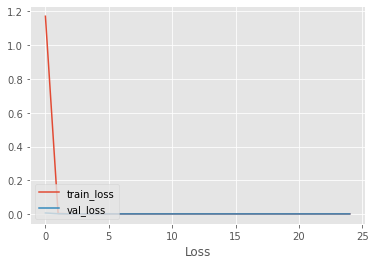

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import imutils
# Número de épocas
N = 25
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), log.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), log.history["val_loss"], label="val_loss")
plt.xlabel("Epochs #")
plt.xlabel("Loss")
plt.legend(loc = "lower left")
plt.savefig("plot.png")

In [ ]:
m=12
#x_test, y_test = loadExample(train_data[m])
x_test, y_test = loadExample(test_data[m])

In [ ]:
print(x_test.shape)
m_x_test = tf.expand_dims(x_test, 0)
print(m_x_test.shape)

(128, 128, 3)
(1, 128, 128, 3)


In [ ]:
(Xmin, Ymin, Xmax, Ymax) = y_test
print(Xmin.numpy(), Ymin.numpy(), Xmax.numpy(), Ymax.numpy())

Yp = modelB.predict(m_x_test)[0]
(Xminp, Yminp, Xmaxp, Ymaxp) = Yp
print(Xminp, Yminp, Xmaxp, Ymaxp)

0.13625304 0.17532468 0.8540146 0.78571427
1/1 [==============================] - 0s 28ms/step
0.14085491 0.20156482 0.8599468 0.8097362


42 22 257 90


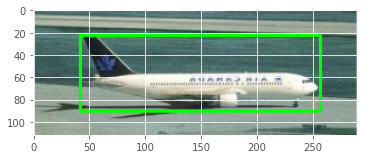

In [ ]:
path=test_data[m].split(",")[0]
img = cv.imread(path)
img = imutils.resize(img, width=300)
h, w = img.shape[:2]

Xminp=int(Xminp * w)
Yminp=int(Yminp * h)
Xmaxp=int(Xmaxp * w)
Ymaxp=int(Ymaxp * h)

print(Xminp, Yminp, Xmaxp, Ymaxp)

img= cv.rectangle(img, (Xminp, Yminp), (Xmaxp, Ymaxp), (0, 255, 0), 2)
#plt.axis("off")
plt.imshow(img)
plt.show()

In [ ]:
path="/content/drive/MyDrive/DL2023p-licd/S07/modelB"
modelB.save(path)

In [ ]:
path="/content/drive/MyDrive/DL2023p-licd/S07/modelB"
modelBS = tf.keras.models.load_model(path)

1/1 [==============================] - 0s 239ms/step
42 22 257 90


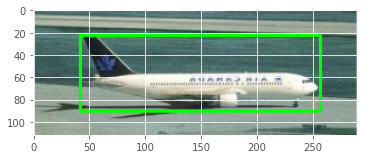

In [ ]:
m=12

x_test, y_test = loadExample(test_data[m])

m_x_test = tf.expand_dims(x_test, 0)

Yp = modelBS.predict(m_x_test)[0]
(Xminp, Yminp, Xmaxp, Ymaxp) = Yp

path=test_data[m].split(",")[0]
img = cv.imread(path)
img = imutils.resize(img, width=300)
h, w = img.shape[:2]

Xminp=int(Xminp * w)
Yminp=int(Yminp * h)
Xmaxp=int(Xmaxp * w)
Ymaxp=int(Ymaxp * h)

print(Xminp, Yminp, Xmaxp, Ymaxp)

img=cv.rectangle(img, (Xminp, Yminp), (Xmaxp, Ymaxp), (0, 255, 0), 2)
#plt.axis("off")
plt.imshow(img)
plt.show()